In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from graphviz import Digraph

def trace(root):
  """Builds a set of all nodes and edges in a graph."""
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  """Creates a Digraph representation of the graph."""
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular ('record') node for it.
    dot.node(name=uid, label="{ %s | data %.4f | grad % .4f }" % (n.label, n.data, n.grad), shape="record")

    if n._op:
      # If this value is a result of some operation, create an op node.
      dot.node(name=uid + n._op, label=n._op)
      # And connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # Connect nl to the op node of n2.
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [3]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward    

        return out

    def __radd__(self, other): # other + self
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)        
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float power for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1
    
    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    # https://en.wikipedia.org/wiki/Hyperbolic_functions
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        # topological sort
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1  # initialize
        for node in reversed(topo):
            node._backward()    

In [4]:
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

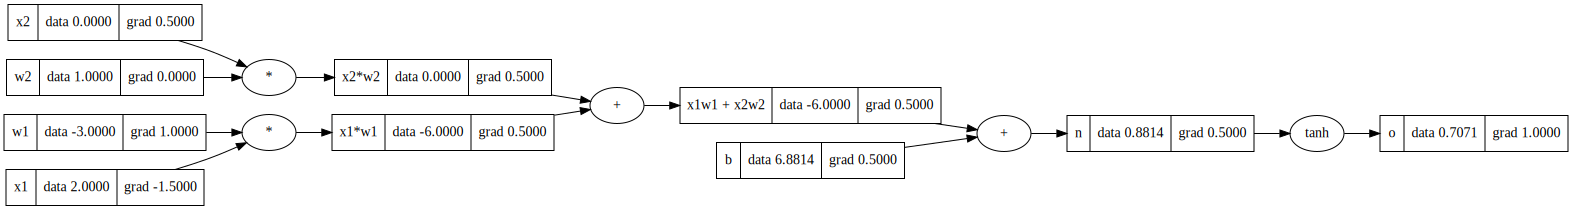

In [5]:
draw_dot(o)

In [6]:
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
#----------
# use tanh definition to calculate tanh
# https://en.wikipedia.org/wiki/Hyperbolic_functions
# o = n.tanh(); o.label = 'o'
e = (2*n).exp(); e.label = 'e'
o = (e - 1) / (e + 1)
#----------
o.backward()

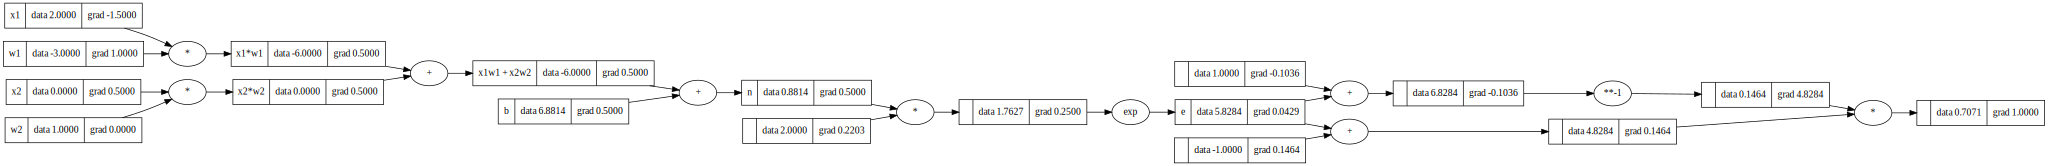

In [7]:
draw_dot(o)

In [8]:
# https://en.wikipedia.org/wiki/Hyperbolic_functions
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o1 = n.tanh(); o.label = 'o1'
# o1.backward()

h = 0.0001
x1 += h

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o2 = n.tanh(); o.label = 'o2'
# o2.backward()
o_grad = (o2 - o1) / h 

print(f'manual calculation of o_grad with respect to x1 = {o_grad}')

manual calculation of o_grad with respect to x1 = Value(data = -1.500318220551966)


In [9]:
import torch

In [10]:
x1 = torch.Tensor([2.0]).double()               ;x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()               ;x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ;w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ;w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ;b.requires_grad  = True
n = x1*w1 + x2*w2 + b
o3 = torch.tanh(n)
o3.backward()

print('---- print torch results matched manual draw_dot(o) results ----')
print(f'x1.data.item() = {x1.data.item()}')
print(f'x1.grad.item() = {x1.grad.item()}')
print(f'w1.data.item() = {w1.data.item()}')
print(f'w1.grad.item() = {w1.grad.item()}')
print('---')
print(f'x2.data.item() = {x2.data.item()}')
print(f'x2.grad.item() = {x2.grad.item()}')
print(f'w2.data.item() = {w2.data.item()}')
print(f'w2.grad.item() = {w2.grad.item()}')
print('---')
print(f'o.data.item()  = {o3.data.item()}')


---- print torch results matched manual draw_dot(o) results ----
x1.data.item() = 2.0
x1.grad.item() = -1.5000003851533106
w1.data.item() = -3.0
w1.grad.item() = 1.0000002567688737
---
x2.data.item() = 0.0
x2.grad.item() = 0.5000001283844369
w2.data.item() = 1.0
w2.grad.item() = 0.0
---
o.data.item()  = 0.7071066904050358


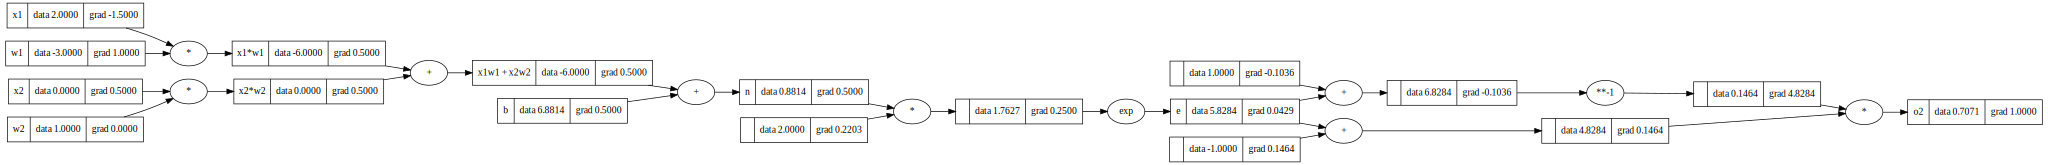

In [11]:
draw_dot(o)

In [12]:
import random

class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Neuron(w = {self.w}, b = {self.b})"
######################################################

    def __call__(self, x):
        # w * x + b
        # print(list(zip(self.w, x)), self.b)
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out

    def parameters(self):
        # print(f'w: {self.w}, b: {[self.b]}')
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Layer(neurons = {self.neurons})"
######################################################

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        # for layer in self.layers:
        #     ps = layer.parameters()
        #     params.extend(ps)
        # return params
        return [p for layer in self.layers for p in layer.parameters()]

In [13]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
print(n.layers) 
n(x)

[Layer(neurons = [Neuron(w = [Value(data = -0.963558900481857), Value(data = -0.020452602372269535), Value(data = -0.894942996231993)], b = Value(data = -0.5101342602862191)), Neuron(w = [Value(data = 0.930546533886158), Value(data = -0.8431092722529598), Value(data = -0.09736100125002212)], b = Value(data = 0.26651886996600127)), Neuron(w = [Value(data = -0.8807637249356752), Value(data = 0.697952818879789), Value(data = 0.7647541812894434)], b = Value(data = -0.0022483091301217506)), Neuron(w = [Value(data = -0.06384217072520881), Value(data = -0.11577659678311236), Value(data = -0.43365855390150365)], b = Value(data = -0.7622486827092594))]), Layer(neurons = [Neuron(w = [Value(data = 0.9343494355813817), Value(data = 0.7698457402973404), Value(data = -0.5212871749289745), Value(data = 0.2809568682734931)], b = Value(data = 0.45383101047242724)), Neuron(w = [Value(data = -0.46321334904518197), Value(data = -0.9780455548064364), Value(data = -0.41460622598545593), Value(data = -0.6793

Value(data = 0.7447830671780954)

In [14]:
print(f'len(n.parameters()): {len(n.parameters())}')
n.parameters()

len(n.parameters()): 41


[Value(data = -0.963558900481857),
 Value(data = -0.020452602372269535),
 Value(data = -0.894942996231993),
 Value(data = -0.5101342602862191),
 Value(data = 0.930546533886158),
 Value(data = -0.8431092722529598),
 Value(data = -0.09736100125002212),
 Value(data = 0.26651886996600127),
 Value(data = -0.8807637249356752),
 Value(data = 0.697952818879789),
 Value(data = 0.7647541812894434),
 Value(data = -0.0022483091301217506),
 Value(data = -0.06384217072520881),
 Value(data = -0.11577659678311236),
 Value(data = -0.43365855390150365),
 Value(data = -0.7622486827092594),
 Value(data = 0.9343494355813817),
 Value(data = 0.7698457402973404),
 Value(data = -0.5212871749289745),
 Value(data = 0.2809568682734931),
 Value(data = 0.45383101047242724),
 Value(data = -0.46321334904518197),
 Value(data = -0.9780455548064364),
 Value(data = -0.41460622598545593),
 Value(data = -0.6793893292770918),
 Value(data = -0.08097897233495055),
 Value(data = 0.2330884976062495),
 Value(data = -0.3766475252

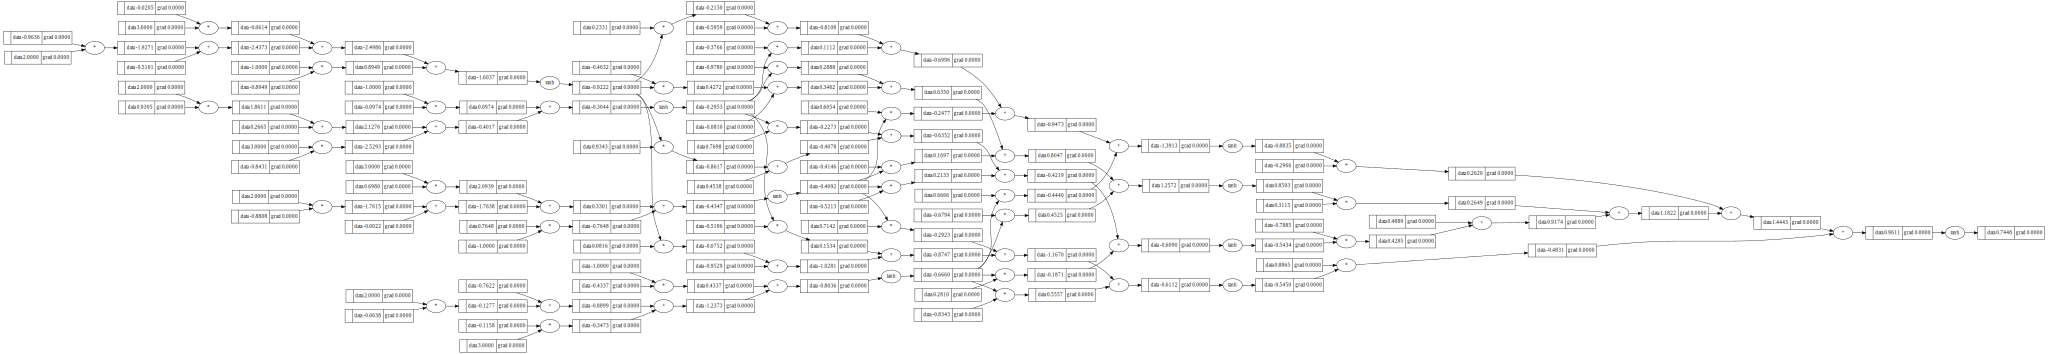

In [15]:
draw_dot(n(x))

In [16]:
# initialize neutral net, 3 inputs, 4 neurons, 4 neurons, 1 output, with random weights and bias
n = MLP(3, [4, 4, 1])

In [17]:
# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0]    
]
  
# desired targets
ys = [1.0, -1.0, -1.0, 1.0]  

In [18]:
# initialize neutral net, 3 inputs, 4 neurons, 1 output, with random weights and bias
n = MLP(3, [2, 1])

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]
  
# desired targets
ys = [1.0, -1.0]

# initialize
step = 0

In [19]:
print(f'len(n.parameters()): {len(n.parameters())}')  # sum of neurons' weights + bias
n.parameters()

len(n.parameters()): 11


[Value(data = 0.5721387975287331),
 Value(data = -0.09286578522905353),
 Value(data = 0.580311606270526),
 Value(data = -0.15022187365390538),
 Value(data = 0.16409035974385522),
 Value(data = -0.08613576340515783),
 Value(data = -0.5863274159378156),
 Value(data = 0.8599141209897139),
 Value(data = -0.37438659176858335),
 Value(data = 0.34576180491871766),
 Value(data = -0.04365499295974962)]

In [20]:
# forward pass
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0

ypred_data = [v.data for v in ypred] 
loss_data = loss.data
print(f'step: {step}')
print(f'ys: {ys}')
print(f'ypred_data: {ypred_data}')
print(f'loss_data: {loss_data}')

step: 0
ys: [1.0, -1.0]
ypred_data: [0.2165234331381896, -0.12038495815134156]
loss_data: 1.387558152667986


In [21]:
layer_cnt = len(n.layers)
w_mats = []
b_mats = []
print(f'layer_cnt: {layer_cnt}\n')
for i, layer in enumerate(n.layers):
    neuron_cnt = len(layer.neurons)
    print(f'layer: {i}, neuron_cnt: {neuron_cnt}')

    print('----')
    b_mat = []  # accumulate neuon's bias for each row     
    for j, neuron in enumerate(layer.neurons):
        print(f'neuron {j}')
        b = neuron.b.data  # bias of neuron 
        w_row = []  # accumulate neuon's weights for each row
        # b_row = []  # accumulate neuon's bias for each row
        for k, w in enumerate(neuron.w):
            w_row.append(w.data)
            print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')
        if j == 0:            
            w_mat = np.array([w_row])
        else:
            w_mat = np.vstack((w_mat, w_row))
        
        b_mat.append(b)
        print(f'b:  {b:10.7f}')
        print(f'b_mat:  {b_mat}')
    w_mats.append(w_mat)  
    b_mats.append(np.array([b_mat]))        
    print('----')

layer_cnt: 2

layer: 0, neuron_cnt: 2
----
neuron 0
w0:  0.5721388,   w0.grad:  0.0000000
w1: -0.0928658,   w1.grad:  0.0000000
w2:  0.5803116,   w2.grad:  0.0000000
b:  -0.1502219
b_mat:  [-0.15022187365390538]
neuron 1
w0:  0.1640904,   w0.grad:  0.0000000
w1: -0.0861358,   w1.grad:  0.0000000
w2: -0.5863274,   w2.grad:  0.0000000
b:   0.8599141
b_mat:  [-0.15022187365390538, 0.8599141209897139]
----
layer: 1, neuron_cnt: 1
----
neuron 0
w0: -0.3743866,   w0.grad:  0.0000000
w1:  0.3457618,   w1.grad:  0.0000000
b:  -0.0436550
b_mat:  [-0.04365499295974962]
----


In [22]:
print(f'w_mats:\n{w_mats}')
print(f'b_mats:\n{b_mats}')


w_mats:
[array([[ 0.5721388 , -0.09286579,  0.58031161],
       [ 0.16409036, -0.08613576, -0.58632742]]), array([[-0.37438659,  0.3457618 ]])]
b_mats:
[array([[-0.15022187,  0.85991412]]), array([[-0.04365499]])]


In [23]:
xs_mats = [np.array(xs)]
xs_mats  

[array([[ 2. ,  3. , -1. ],
        [ 3. , -1. ,  0.5]])]

In [24]:
print(f'type(w_mats): {type(w_mats)}')
print(f'type(w_mats[0]): {type(w_mats[0])}')
print(f'w_mats[0].shape: {w_mats[0].shape}')
print(f'w_mats[0]: {w_mats[0]}\n')
print(f'type(xs_mats): {type(xs_mats)}')
print(f'type(xs_mats[0]): {type(xs_mats[0])}')
print(f'xs_mats[0].shape: {xs_mats[0].shape}')
print(f'xs_mats[0]: {xs_mats[0]}\n')
print(f'type(b_mats): {type(b_mats)}')
print(f'type(b_mats[0]): {type(b_mats[0])}')
print(f'b_mats[0].shape: {b_mats[0].shape}')
print(f'b_mats[0]: {b_mats[0]}\n')

type(w_mats): <class 'list'>
type(w_mats[0]): <class 'numpy.ndarray'>
w_mats[0].shape: (2, 3)
w_mats[0]: [[ 0.5721388  -0.09286579  0.58031161]
 [ 0.16409036 -0.08613576 -0.58632742]]

type(xs_mats): <class 'list'>
type(xs_mats[0]): <class 'numpy.ndarray'>
xs_mats[0].shape: (2, 3)
xs_mats[0]: [[ 2.   3.  -1. ]
 [ 3.  -1.   0.5]]

type(b_mats): <class 'list'>
type(b_mats[0]): <class 'numpy.ndarray'>
b_mats[0].shape: (1, 2)
b_mats[0]: [[-0.15022187  0.85991412]]



In [25]:
xs_mats_T = []

for mat in xs_mats:
  print(f'mat: {mat}')
  mat_transpose = np.transpose(mat)
  print(f'mat_transpose: {mat_transpose}')
  xs_mats_T.append(mat_transpose)

xs_mats_T

mat: [[ 2.   3.  -1. ]
 [ 3.  -1.   0.5]]
mat_transpose: [[ 2.   3. ]
 [ 3.  -1. ]
 [-1.   0.5]]


[array([[ 2. ,  3. ],
        [ 3. , -1. ],
        [-1. ,  0.5]])]

In [26]:
np.matmul(w_mats[0],xs_mats_T[0]) 

array([[0.28536863, 2.09943798],
       [0.65610085, 0.28524313]])

In [27]:
b_mats[0]
mat_transpose = np.transpose(mat)

In [28]:
# output of layer 0
out_0 = np.tanh(np.matmul(w_mats[0],xs_mats_T[0]) + np.transpose(b_mats[0])) 
out_1 = np.tanh(np.matmul(w_mats[1],out_0) + np.transpose(b_mats[1])) 
out_1


array([[ 0.21652343, -0.12038496]])

In [29]:

out_1 = np.tanh(np.matmul(w_mats[1],out_0) + np.transpose(b_mats[1])) 
out_1

array([[ 0.21652343, -0.12038496]])

In [30]:
def convert_array_shape(array):
  """Converts the shape of a NumPy array from (1, 2) to (2, 1).

  Args:
    array: The NumPy array to be converted.

  Returns:
    The converted array.
  """

  # Get the array data.
  array_data = array.reshape(-1)

  # Reshape the array to (2, 1).
  array_reshaped = array_data.reshape(2, 1)

  return array_reshaped

if __name__ == "__main__":
  array = np.array([1, 2])
  array_reshaped = convert_array_shape(array)
  print(array_reshaped)

[[1]
 [2]]


In [31]:
print(w_mats[0])
print(xs_mats[0])
xs_mats_conv = convert_array_shape(xs_mats[0])
print(xs_mats_conv)
print(w_mats[0]*xs_mats_conv[0])
print(b_mats[0])

[[ 0.5721388  -0.09286579  0.58031161]
 [ 0.16409036 -0.08613576 -0.58632742]]
[[ 2.   3.  -1. ]
 [ 3.  -1.   0.5]]


ValueError: cannot reshape array of size 6 into shape (2,1)

In [ ]:
w_mats[0]*xs_mats[0] + convert_array_shape(b_mats[0])

In [ ]:
print(b_mats[0])
b_mats[0][:, np.newaxis]

In [ ]:
w_mats[0]
type(w_mats[0])
b_mats[0]
type(b_mats[0])

In [ ]:
print(f'step: {step}')
for i, layer in enumerate(n.layers):
    print(f'layer {i}')
    print('----')    
    for j, neuron in enumerate(layer.neurons):
        print(f'neuron {j}') 
        for k, w in enumerate(neuron.w):
            # print(f'w{k}: {w.data}')
            print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')            
        print(f'b:  {neuron.b.data:10.7f}')    
    print('----')

# backward pass
for p in n.parameters():
  p.grad = 0.0  # zero the gradient 
loss.backward()

# update weights and bias
learning_rate = 0.05
for p in n.parameters():
    p.data += -learning_rate * p.grad

step += 1
print(f'next step: {step}')

In [ ]:
learning_rate = 0.05

for k in range(200):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0

  # backward pass
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  print('-------')  

In [ ]:
n.parameters()

In [ ]:
print(f'n.layers[0].neurons[0].w[0].data = {n.layers[0].neurons[0].w[0].data}')
print(f'n.layers[0].neurons[0].w[0].grad = {n.layers[0].neurons[0].w[0].grad}')

In [ ]:
draw_dot(loss)

In [ ]:
def lol():  # calculate gradients

  h = .0001

  a = Value(2, label='a')
  b = Value(-3, label='b')
  c = Value(10, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2, label='f')
  L = d * f; L.label='L'
  L1 = L.data

  # add h to variables to get gradient
  a = Value(2, label='a')
  # a.data += h  # dL/da
  b = Value(-3, label='b')
  b.data += h  # dL/db
  c = Value(10, label='c')
  # c.data += h  # dL/dc
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  # d.data += h  # dL/dd
  f = Value(-2, label='f')
  L = d * f; L.label='L'
  L2 = L.data

  print(f'(L2 -L1)/h = {(L2 -L1)/h}')

lol()
        

In [ ]:
_num = np.arange(-5, 5, 0.2)
plt.plot(_num, np.tanh(_num))
plt.grid()